## This script introduces auto operator differentiation using CTorch operators

#### Import python package 

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use("dark_background")
plt.rcParams['image.cmap'] = 'gray'

#### Import CTorch package 

In [2]:
import CTorch.utils.geometry as geometry
from CTorch.projector.projector_interface import Projector

#### Define [geometry](./2_geometry.ipynb)

Here we take 2D geometry as an example, fbp with 3D geoemtry can be done in the same way

In [3]:
nx, ny = 512,512 # image dimension
dx, dy = 0.8, 0.8 # image pixel size

nu = 1024 # detector length 
du = 1.0 # detecor pixel size
nView = 720 # number of views
viewAngles = np.arange(0,-2*np.pi,-2*np.pi/nView) # projection angle
detType = 'curve' #'curve'
SAD, SDD = [800.0], [1200.0] # source-axis-distance, source-detector-distance

xOfst, yOfst = [0.0], [0.0] # image center offset
uOfst = [0.0] # detecor center offset
xSrc = [100.0]

# define geometry object
geom = geometry.Geom2D(nx, ny, dx, dy, nu, nView, viewAngles, du, detType, SAD, SDD, 
                 xOfst = xOfst, yOfst = yOfst, uOfst = uOfst, xSrc = xSrc, fixed=True)  


#### Define [projector](./3_projector.ipynb)

In [4]:
projAlgo = 'SF' 
A = Projector(geom,'proj', projAlgo,'forward')

#### Load example data

In [5]:
batch_size = 1 # number of images per batch
channel_size = 1 # number of image channels

img = io.loadmat("img_example.mat")["img"]
img = torch.Tensor(img).reshape([1,1,ny,nx]).cuda()
img = img.repeat(batch_size, channel_size, 1, 1)

#### Sinogram simulation

In [6]:
sino = A(img)

#### Let's do an iterative CT recosntruction (IR). IR minimizes $\|Ax-y\|_2^2$ by gradient descent

- In the following example, gradient("grad") can be automatically computed once we specify the forward path to compute the loss. 

- The gradient of objective function is $A^T(Ax-y)$, however, the PyTorch auto-differentiation engine can automatically call forward projector and back projector to compute the gradient.

- The same mechanism also works for non-linear user-defined loss functions

In [7]:
num_iter, lr = 1000, 1e0 # number of iterations and step size

x = torch.zeros_like(img, requires_grad=True).cuda()
for i in range(num_iter):
    loss = torch.nn.functional.mse_loss(A(x), sino)
    grad = torch.autograd.grad(loss, [x], retain_graph=False)[0]
    x.data -= lr * grad

    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 5.3625030517578125
Iteration 10, Loss: 0.09847673028707504
Iteration 20, Loss: 0.03348938003182411
Iteration 30, Loss: 0.015829911455512047
Iteration 40, Loss: 0.008964717388153076
Iteration 50, Loss: 0.005710636265575886
Iteration 60, Loss: 0.003943263553082943
Iteration 70, Loss: 0.002884076675400138
Iteration 80, Loss: 0.002200671937316656
Iteration 90, Loss: 0.0017338953912258148
Iteration 100, Loss: 0.0014004684053361416
Iteration 110, Loss: 0.0011536055244505405
Iteration 120, Loss: 0.0009654495515860617
Iteration 130, Loss: 0.000818585220258683
Iteration 140, Loss: 0.0007016678573563695
Iteration 150, Loss: 0.0006070398376323283
Iteration 160, Loss: 0.0005293730646371841
Iteration 170, Loss: 0.0004648595640901476
Iteration 180, Loss: 0.0004107144195586443
Iteration 190, Loss: 0.00036485856981016695
Iteration 200, Loss: 0.00032571301562711596
Iteration 210, Loss: 0.0002920582774095237
Iteration 220, Loss: 0.00026294056442566216
Iteration 230, Loss: 0.0002376034

- We can also use [PyTorch-style network training](https://pytorch.org/docs/stable/optim.html) to do the optimization

In [8]:
num_iter, lr = 1000, 1e0 # number of iterations and step size

x = torch.zeros_like(img, requires_grad=True).cuda()
optimizer = torch.optim.SGD([x], lr=lr)

for i in range(num_iter):
    loss = torch.nn.functional.mse_loss(A(x), sino)
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad() # NOTE: this is important

    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

Iteration 0, Loss: 5.3625030517578125
Iteration 10, Loss: 0.09847673028707504
Iteration 20, Loss: 0.03348938003182411
Iteration 30, Loss: 0.015829911455512047
Iteration 40, Loss: 0.008964717388153076
Iteration 50, Loss: 0.005710636265575886
Iteration 60, Loss: 0.003943263553082943
Iteration 70, Loss: 0.002884076675400138
Iteration 80, Loss: 0.0022006717044860125
Iteration 90, Loss: 0.0017338955076411366
Iteration 100, Loss: 0.0014004686381667852
Iteration 110, Loss: 0.0011536054080352187
Iteration 120, Loss: 0.0009654493187554181
Iteration 130, Loss: 0.0008185851038433611
Iteration 140, Loss: 0.0007016677409410477
Iteration 150, Loss: 0.0006070397794246674
Iteration 160, Loss: 0.0005293731228448451
Iteration 170, Loss: 0.00046485962229780853
Iteration 180, Loss: 0.0004107143322471529
Iteration 190, Loss: 0.0003648585407063365
Iteration 200, Loss: 0.00032571301562711596
Iteration 210, Loss: 0.0002920582192018628
Iteration 220, Loss: 0.00026294056442566216
Iteration 230, Loss: 0.00023760

- Let's use advanced optimization algorithm, e.g. [Adam](https://arxiv.org/abs/1412.6980)

In [9]:
num_iter, lr = 1000, 1e-3 # number of iterations and step size

x = torch.zeros_like(img, requires_grad=True).cuda()
optimizer = torch.optim.Adam([x], lr=lr)

for i in range(num_iter):
    loss = torch.nn.functional.mse_loss(A(x), sino)
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")
        
imgr = x.clone()

Iteration 0, Loss: 5.3625030517578125
Iteration 10, Loss: 1.037361979484558
Iteration 20, Loss: 0.28160783648490906
Iteration 30, Loss: 0.20415706932544708
Iteration 40, Loss: 0.07682737708091736
Iteration 50, Loss: 0.02758731134235859
Iteration 60, Loss: 0.01909565180540085
Iteration 70, Loss: 0.01152048446238041
Iteration 80, Loss: 0.0069703408516943455
Iteration 90, Loss: 0.004798142705112696
Iteration 100, Loss: 0.0034141114447265863
Iteration 110, Loss: 0.00260600121691823
Iteration 120, Loss: 0.00202224962413311
Iteration 130, Loss: 0.0016075762687250972
Iteration 140, Loss: 0.00129459158051759
Iteration 150, Loss: 0.0010563594987615943
Iteration 160, Loss: 0.0008705528452992439
Iteration 170, Loss: 0.000723585020750761
Iteration 180, Loss: 0.0006058307480998337
Iteration 190, Loss: 0.00051055260701105
Iteration 200, Loss: 0.00043277343502268195
Iteration 210, Loss: 0.00036879803519695997
Iteration 220, Loss: 0.0003158145700581372
Iteration 230, Loss: 0.0002716638264246285
Iterat

#### Display results

In [10]:
sino = sino.squeeze().cpu().detach().numpy()
imgr = imgr.squeeze().cpu().detach().numpy()
img = img.squeeze().cpu().detach().numpy()

Text(0.5, 1.0, 'Iterative reconstruction (left) and ground truth (right)')

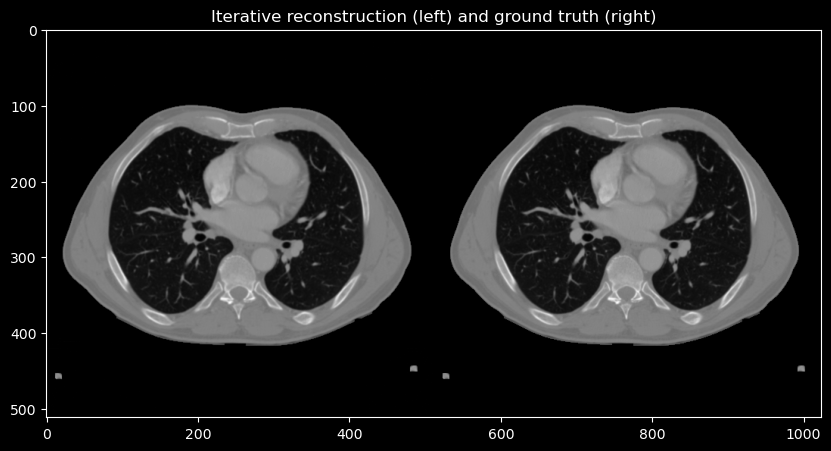

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((imgr,img)),vmin = 0.00,vmax=0.04)
plt.title('Iterative reconstruction (left) and ground truth (right)')